In [1]:
#Description:  010-SQLAlchemy_Homework
#
#
#   Modification Summary:
#   DD-MMM-YYYY    Author          Description
#   31-Jul-2019    Stacey Smith     Initial Creation
#
#

In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

conn = engine.connect()
inspector = inspect(engine)

In [7]:
# Get table information
inspector.get_table_names()

tables = inspector.get_table_names()
for table in tables:
    print(table)
    columns = inspector.get_columns(table)
    for column in columns:
        print('   ', column["name"], column["type"])

measurement
    id INTEGER
    station TEXT
    date TEXT
    prcp FLOAT
    tobs FLOAT
station
    id INTEGER
    station TEXT
    name TEXT
    latitude FLOAT
    longitude FLOAT
    elevation FLOAT


In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(func.max(measurement.date))
for row in max_date:
    last_date = dt.datetime.strptime((str(row)).strip("('',)"), '%Y-%m-%d')
   
one_year = last_date - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
prcp_year = session.query(measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs).\
    filter(measurement.date < max_date).\
    filter(measurement.date > one_year)
   
prcp_data = []
    
for i in prcp_year:
   prcp_data.append(i)
 

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

prcp = pd.DataFrame(prcp_data)
prcp_date = prcp.set_index('date')
prcp_date.sort_values(by=['date'])

# Creating 364 data points for the plot below.  Plotting the total precipitation by date between Aug 2016 and Aug 2017
prcp_plot = prcp_date.groupby(level=0).sum()

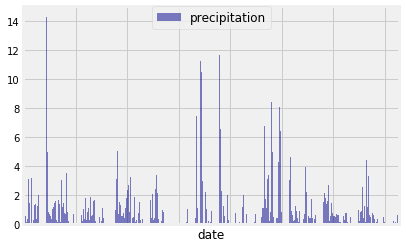

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data (precipitation by date)
dates = prcp_plot.index.values
prcp = prcp_plot['prcp']
x_axis = np.arange(len(dates))


plt.bar(x_axis, prcp, color='darkblue', alpha=0.5, align='center', label='precipitation')

plt.legend(loc='upper center', borderaxespad=0, fontsize = 12) 

plt.tick_params(axis = 'x', bottom=False, labelbottom=False)

plt.xlim(-1, len(x_axis))

plt.xlabel("date")

plt.savefig("Images/Precipitation_by_Date.png")
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_date.describe()


,id,prcp,tobs
count,2219.000000,2011.000000,2219.000000
mean,10158.739973,0.176549,74.568725
std,5603.129354,0.460667,4.608881
min,2365.000000,0.000000,58.000000
25%,5287.500000,0.000000,71.000000
50%,8931.000000,0.020000,75.000000
75%,14751.500000,0.130000,78.000000
max,19549.000000,6.700000,87.000000


# Station Analysis

In [15]:
# Design a query to show how many stations are available in this dataset?
# It's not clear which dataset they are referring to. So I'll calculate the number of stations in each one. 

#measurement
m_station_count = session.query(measurement.station).count()
print(m_station_count)

#station
s_station_count = session.query(station.station).distinct().count()
print(s_station_count)

19550
9


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

def takeSecond(elem):
    return elem[1]

active_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).all()
active_stations.sort(key=takeSecond, reverse=True)
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

low_temp = session.query(func.min(measurement.tobs)).filter_by(station='USC00519281')
for row in low_temp:
    print(f' The low temp for station USC00519281 is {str(row).strip("(,)")}')

high_temp = session.query(func.max(measurement.tobs)).filter_by(station='USC00519281')
for row in high_temp:
    print(f' The high temp for station USC00519281 is {str(row).strip("(,)")}')
          
avg_temp = session.query(func.avg(measurement.tobs)).filter_by(station='USC00519281')
for row in avg_temp:
    print(f' The average temp for station USC00519281 is {str(row).strip("(,)")}')          


 The low temp for station USC00519281 is 54.0
 The high temp for station USC00519281 is 85.0
 The average temp for station USC00519281 is 71.66378066378067


In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Filter by the station with the highest number of observations.


tobs_year = session.query(measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs).\
    filter(measurement.date < max_date).\
    filter(measurement.date > one_year).\
    filter(measurement.station=='USC00519281')
   
tobs_data = []
    
for i in tobs_year:
    tobs_data.append(i)

tobs = pd.DataFrame(tobs_data)
tobs.head()

,id,station,date,prcp,tobs
0,14609,USC00519281,2016-08-24,2.15,77.0
1,14610,USC00519281,2016-08-25,0.06,80.0
2,14611,USC00519281,2016-08-26,0.01,80.0
3,14612,USC00519281,2016-08-27,0.12,75.0
4,14613,USC00519281,2016-08-28,0.60,73.0


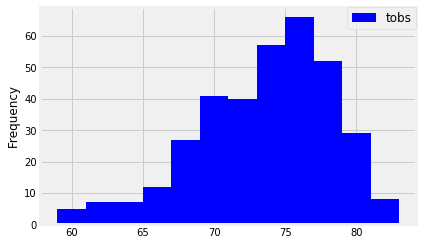

In [19]:
#Plot the results as a histogram with bins=12
x = tobs['tobs']
bins = 12

fig = plt.figure()


n, bins, patches = plt.hist(x, bins, facecolor='blue', label='tobs')


plt.legend(loc='upper right', borderaxespad=0, fontsize = 12) 
plt.ylabel('Frequency')

plt.savefig("Images/Tobs_Frequency.png")
plt.show()
